In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sys
import os
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
!pwd

/Users/bhavi/Documents/Projects/CristianoRonaldo


In [3]:
df = pd.read_csv("/Users/bhavi/Documents/Projects/CristianoRonaldo/Cristano_Ronaldo_Final_v1/data.csv")

In [4]:
df = df.rename(columns={'lat/lng':'lat_lng',\
                        'distance_of_shot.1': 'distance_of_shot_1', \
                        'remaining_min.1':'remaining_min_1', \
                        'power_of_shot.1':'power_of_shot_1', \
                        'knockout_match.1' : 'knockout_match_1', \
                        'remaining_sec.1' : 'remaining_sec_1'})


print (df[df.match_id.isnull()].shape) # match_id is never null


for col in df.columns:
    print (f"'{col}'", end=',')

(0, 28)
'Unnamed: 0','match_event_id','location_x','location_y','remaining_min','power_of_shot','knockout_match','game_season','remaining_sec','distance_of_shot','is_goal','area_of_shot','shot_basics','range_of_shot','team_name','date_of_game','home/away','shot_id_number','lat_lng','type_of_shot','type_of_combined_shot','match_id','team_id','remaining_min_1','power_of_shot_1','knockout_match_1','remaining_sec_1','distance_of_shot_1',

In [5]:
df.describe()

,Unnamed: 0,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,is_goal,shot_id_number,match_id,team_id,remaining_min_1,power_of_shot_1,knockout_match_1,remaining_sec_1,distance_of_shot_1
count,30697.000000,29134.000000,29236.000000,29157.000000,29135.000000,29211.000000,29180.000000,29103.000000,29130.000000,24429.000000,29134.000000,3.069700e+04,3.069700e+04,29162.000000,29158.000000,29204.000000,29158.000000,29129.000000
mean,15348.000000,249.576028,7.383876,91.126933,4.883233,2.519359,0.145956,28.329382,33.448884,0.445331,15368.581039,2.476407e+07,1.610613e+09,18.204615,15.994109,16.599402,39.027303,38.801852
std,8861.604943,150.186019,110.263049,87.676395,3.452533,1.153976,0.353068,17.470663,9.369656,0.497013,8866.520772,7.755175e+06,0.000000e+00,29.416973,29.676815,35.172016,29.835284,18.787711
min,0.000000,2.000000,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,1.000000,2.000001e+07,1.610613e+09,0.000000,1.000000,0.000000,0.000000,9.400000
25%,7674.000000,111.000000,-68.000000,4.000000,2.000000,1.000000,0.000000,13.000000,25.000000,0.000000,7693.250000,2.050008e+07,1.610613e+09,3.000000,2.000000,0.000000,17.000000,26.000000
50%,15348.000000,254.000000,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,35.000000,0.000000,15378.500000,2.090035e+07,1.610613e+09,6.000000,3.000000,0.000000,35.000000,36.000000
75%,23022.000000,369.000000,95.000000,160.000000,8.000000,3.000000,0.000000,43.000000,41.000000,1.000000,23055.750000,2.960047e+07,1.610613e+09,11.000000,4.000000,1.000000,52.000000,44.000000
max,30696.000000,659.000000,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,99.000000,1.000000,30697.000000,4.990009e+07,1.610613e+09,128.761600,118.360000,141.352320,144.785600,115.728000


In [6]:
df.corr()

,Unnamed: 0,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,remaining_sec,distance_of_shot,is_goal,shot_id_number,match_id,team_id,remaining_min_1,power_of_shot_1,knockout_match_1,remaining_sec_1,distance_of_shot_1
Unnamed: 0,1.000000,0.031239,-0.020904,0.031881,-0.004952,0.002229,0.611755,-0.004785,0.015183,-0.012693,1.000000,0.761656,NaN,0.007058,0.000610,0.005797,0.003001,0.003279
match_event_id,0.031239,1.000000,-0.030212,0.059463,-0.272789,0.956095,-0.001414,-0.022830,0.061072,-0.038705,0.029223,0.000789,NaN,-0.043133,0.022375,-0.001657,-0.003767,0.026465
location_x,-0.020904,-0.030212,1.000000,-0.014907,0.007889,-0.028939,-0.012840,0.001631,0.023483,-0.004728,-0.020701,-0.020021,NaN,0.002110,-0.000150,0.005408,0.006466,0.004695
location_y,0.031881,0.059463,-0.014907,1.000000,-0.074579,0.041263,0.001962,-0.050964,0.818727,-0.145413,0.032438,-0.013659,NaN,-0.010678,-0.000933,0.009672,-0.022644,0.323209
remaining_min,-0.004952,-0.272789,0.007889,-0.074579,1.000000,-0.043992,0.014806,0.026664,-0.058495,0.028342,-0.003587,0.014595,NaN,0.098414,-0.004447,-0.010549,0.016655,-0.022925
power_of_shot,0.002229,0.956095,-0.028939,0.041263,-0.043992,1.000000,0.010686,0.003066,0.046184,-0.034698,0.001088,0.011857,NaN,-0.018268,0.026339,-0.003296,0.007004,0.023045
knockout_match,0.611755,-0.001414,-0.012840,0.001962,0.014806,0.010686,1.000000,-0.000886,-0.009546,0.001152,0.612181,0.917184,NaN,0.005961,0.001193,0.009470,-0.003515,0.000299
remaining_sec,-0.004785,-0.022830,0.001631,-0.050964,0.026664,0.003066,-0.000886,1.000000,-0.049875,0.028964,-0.005976,-0.004893,NaN,0.006628,0.002475,0.002258,0.464134,-0.018455
distance_of_shot,0.015183,0.061072,0.023483,0.818727,-0.058495,0.046184,-0.009546,-0.049875,1.000000,-0.198234,0.016110,-0.031433,NaN,-0.006094,0.000784,0.006642,-0.025477,0.398123
is_goal,-0.012693,-0.038705,-0.004728,-0.145413,0.028342,-0.034698,0.001152,0.028964,-0.198234,1.000000,-0.010696,-0.000169,NaN,0.008384,-0.001363,-0.001224,0.012209,-0.075195


In [7]:
# pd.scatter_matrix(df[['match_event_id','remaining_min','remaining_sec', 'remaining_min_1', 'remaining_sec_1', 'distance_of_shot_1']], alpha=0.6, figsize=(10, 10), diagonal='kde')
# plt.show()

In [8]:
'''
    Filling Missing Values of game_season by padding on previous values
'''

print(df[df.game_season.isnull()].shape)
df['game_season'] = df['game_season'].fillna(method='pad')

df['game_season'] = df['game_season'].apply(
    lambda x: x.split('-')[0]
)

print(df[df.game_season.isnull()].shape)


(5862, 28)
(0, 28)


In [9]:
'''
    Filling Missing Values of date_of_game by padding on previous values
'''

print(df[df.date_of_game.isnull()].shape)
df['date_of_game'] = df['date_of_game'].fillna(method='pad')

print(df[df.date_of_game.isnull()].shape)

'''
    Generating new features for day month and year
'''

df['day'] = df['date_of_game'].apply(
    lambda x: x.split('-')[0]
)

df['month'] = df['date_of_game'].apply(
    lambda x: x.split('-')[1]
)

df['year'] = df['date_of_game'].apply(
    lambda x: x.split('-')[2]
)

(1550, 28)
(0, 28)


In [10]:
'''
    Filling Missing Values of lat_lng by padding on previous values
'''

print(df[df.lat_lng.isnull()].shape)
df['lat_lng'] = df['lat_lng'].fillna(method='pad')

print(df[df.lat_lng.isnull()].shape)

'''
    lat_lng is categorical based on arena of match - we can label encode it
'''
print(df.lat_lng.unique().shape)
df['lat_lng'] = df['lat_lng'].astype('category').cat.codes

(1565, 31)
(0, 31)
(38,)


In [11]:
# Match Event Id

# for i in range(2, len(df[df.match_event_id.isnull()])):
#     df.loc[i, 'match_event_id'] = df.loc[i-1, 'match_event_id']

'''
    Fill Missing Match Event Id By Looking at Row Above And Below with same Game Id,
    pass in case of any error.
'''
for index, row in df[df.match_event_id.isnull()].iterrows():
    try:
        if df.loc[index - 1, 'match_id'] == row['match_id']:
            df.loc[index, 'match_event_id'] = int(df.loc[index-1, 'match_event_id']) + 1
        elif df.loc[index + 1, 'match_id'] == row['match_id']:
            df.loc[index, 'match_event_id'] = int(df.loc[index+1, 'match_event_id']) + 1
        else:
            df.loc[index, 'match_event_id'] = int(df.loc[index-1, 'match_event_id']) + 1
    except:
        pass

'''
    Fill Remaining Rows(only 10) with mode value
'''
df['match_event_id'] = df['match_event_id'].fillna(method='pad')
# df['match_event_id'].fillna(df['match_event_id'].mode()[0], inplace=True)

In [12]:
'''
    Filling Missing Valued For Knockout Matches
'''
def fillKnockoutMatches(row):
    if row.name >= 26198:
        return 1
    else:
        return 0
    
df['knockout_match'] = df['knockout_match'].fillna(method='pad')

In [13]:
'''
    Filling some Distance Of Shot Feature values based on another feature by the same name.
    Second feature has noise in form of decimal numbers, so making sure that is not used
'''

df['distance_of_shot'] = df.apply(
    lambda row: row['distance_of_shot_1'] if np.isnan(row['distance_of_shot']) and (row['distance_of_shot_1']).is_integer() else row['distance_of_shot'],
    axis=1
)
# Filling remaing missing distance values with mean
df['distance_of_shot'].fillna(df['distance_of_shot'].mean(), inplace=True)


df['remaining_min'] = df.apply(
    lambda row: row['remaining_min_1'] if np.isnan(row['remaining_min']) and (row['remaining_min_1']).is_integer() else row['remaining_min'],
    axis=1
)
'''
    Time Remaining has no significant correlation with any of the features. Replacing missing 
    values of it by mean value of feature
'''
df['remaining_min'].fillna(df['remaining_min'].mean(), inplace=True)

In [ ]:
'''
    Preprocessing area field to contain only area abbreviation
'''
def findArea(x):
    if type(x) == float and np.isnan(x):
        return x
    else:
        return x.split('(')[1].split(')')[0]

df["area_of_shot"] = df["area_of_shot"].apply(findArea)

'''
    Label encoding area of shot. It encodes NaN value as -1. This will be handled as a different category when we One Hot Encode this while training.
'''

# print(df['area_of_shot'])
df['area_of_shot'] = df['area_of_shot'].astype('category').cat.codes
# print(df['area_of_shot'])

In [17]:
'''
    Preprocessing Range of Shot to give lower and upper range
'''
def processRangeOfShot(row):
    range_of_shot = str(row['range_of_shot'])
    try:
        if "Less Than" in range_of_shot:
            return 0, 8
        elif "+" in range_of_shot:
            return 24, 32
        else:
            low = range_of_shot.split('-')[0]
            high = range_of_shot.split('-')[1][0:2]
            return low, high
    except Exception as e:
        return float('NaN'), float('NaN')
    
df['lower_range'], df['upper_range'] = zip(*df.apply(processRangeOfShot, axis=1))

'''
    Filling Remaining values with mode of feature
'''

df['lower_range'].fillna(df['lower_range'].mode()[0], inplace=True)
df['upper_range'].fillna(df['upper_range'].mode()[0], inplace=True)

In [18]:
''' 
    Processing Home/away
'''
def processHome(row):
    val = row['home/away']
    try:
        if '@' in val:
            return 0
        elif 'vs' in val:
            return 1
    except:
        return val
    
df['home'] = df.apply(processHome, axis=1)

'''
    Filling Missing Values
'''
df['home'] = df['home'].fillna(method='pad')

In [19]:
'''
    One of 'type_of_shot' and 'type_of_combined_shot' is always present in data
'''

print(df[df.type_of_shot.isnull() & df.type_of_combined_shot.isnull()].shape)

'''
    Label encoding type_of_shot and type_of_combined_shot. It encodes NaN value as -1. This will be handled when we One Hot Encode this while training.
'''
df['type_of_shot'] = df['type_of_shot'].astype('category').cat.codes
df['type_of_combined_shot'] = df['type_of_combined_shot'].astype('category').cat.codes

(0, 34)


In [20]:
'''
    Filling Missing data with mode and then label encoding
'''

df['shot_basics'].fillna(df['shot_basics'].mode()[0], inplace=True)
df['shot_basics'] = df['shot_basics'].astype('category').cat.codes

In [21]:
for col in df.columns:
    print (f"'{col}'", end=',')

'Unnamed: 0','match_event_id','location_x','location_y','remaining_min','power_of_shot','knockout_match','game_season','remaining_sec','distance_of_shot','is_goal','area_of_shot','shot_basics','range_of_shot','team_name','date_of_game','home/away','shot_id_number','lat_lng','type_of_shot','type_of_combined_shot','match_id','team_id','remaining_min_1','power_of_shot_1','knockout_match_1','remaining_sec_1','distance_of_shot_1','day','month','year','lower_range','upper_range','home',

In [22]:
'''
    Finding Missing Values Of power_of_shot which has high correlation with match_event_id by a logistic regression model
'''
def logisticRegressionForPowerOfShot(data):    
    from sklearn.linear_model import LogisticRegression
    linreg = LogisticRegression()

    sub = data[data.power_of_shot.notnull()]
    sub = sub[sub.match_event_id.notnull()]
    X_train = sub[['match_event_id']]
    y_train = sub[['power_of_shot']]

    sub = data[data.power_of_shot.isnull()]
    sub = sub[sub.match_event_id.notnull()]
    X_test = sub[['match_event_id']]

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    linreg.fit(X_train, y_train)

    predicted = linreg.predict(X_test)

    print (data[data.power_of_shot.isnull()].shape, predicted.shape)

    print (predicted.mean(), data[data.power_of_shot.notnull()]['power_of_shot'].mean())

    data.loc[data.power_of_shot.isnull() & data.match_event_id.notnull() , 'power_of_shot'] = predicted 
    
    return data

df = logisticRegressionForPowerOfShot(df.copy())

# df = df.drop(df[df.location_x.isnull()].index)

df['power_of_shot'].fillna(df['power_of_shot'].mode()[0], inplace=True)

(1486, 34) (1486,)
2.588829071332436 2.51935914552737


/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [23]:
df[['location_x', 'location_y', 'distance_of_shot']].corr()

,location_x,location_y,distance_of_shot
location_x,1.000000,-0.014907,0.023664
location_y,-0.014907,1.000000,0.814661
distance_of_shot,0.023664,0.814661,1.000000


In [24]:
'''
    Finding Missing Values Of Location_x by a linear regression model
'''
def linearRegressionForLocation_X(data):    
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()

    sub = data[data.location_x.notnull()]
    sub = sub[sub.location_y.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_train = sub[['location_y', 'distance_of_shot', 'lower_range', 'upper_range']]
    y_train = sub[['location_x']]

    sub = data[data.location_x.isnull()]
    sub = sub[sub.location_y.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_test = sub[['location_y', 'distance_of_shot', 'lower_range', 'upper_range']]

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    linreg.fit(X_train, y_train)

    predicted = linreg.predict(X_test)

    print (data[data.location_x.isnull()].shape, predicted.shape)

    print (predicted.mean(), data[data.location_x.notnull()]['location_x'].mean())

    data.loc[data.location_x.isnull() & \
             data.location_y.notnull() & \
            data.distance_of_shot.notnull() & \
            data.lower_range.notnull() & \
            data.upper_range.notnull(), 'location_x'] = predicted 
    
    return data

df = linearRegressionForLocation_X(df.copy())

# df = df.drop(df[df.location_x.isnull()].index)

df['location_x'].fillna(df['location_x'].mean(), inplace=True)


(1461, 34) (1383, 1)
7.225532136850007 7.383876043234369


/Users/bhavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/bhavi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [25]:
'''
    Finding Missing Values Of Location_y by a linear regression model
'''
def linearRegressionForLocation_Y(data):
    from sklearn.linear_model import LinearRegression

    linreg = LinearRegression()

    sub = data[data.location_y.notnull()]
    sub = sub[sub.location_x.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_train = sub[['location_x', 'distance_of_shot', 'lower_range', 'upper_range']]
    y_train = sub[['location_y']]

    print (X_train.shape, y_train.shape)

    sub = data[data.location_y.isnull()]
    sub = sub[sub.location_x.notnull()][sub.distance_of_shot.notnull()][sub.lower_range.notnull()][sub.upper_range.notnull()]
    X_test = sub[['location_x', 'distance_of_shot', 'lower_range', 'upper_range']]

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    linreg.fit(X_train, y_train)

    predicted = linreg.predict(X_test)

    print (data[data.location_y.isnull()].shape, predicted.shape)

    print (predicted.mean(), data[data.location_y.notnull()]['location_y'].mean())

    data.loc[data.location_y.isnull() & \
             data.location_x.notnull() & \
            data.distance_of_shot.notnull() & \
            data.lower_range.notnull() & \
            data.upper_range.notnull(), 'location_y'] = predicted 
    return data

df = linearRegressionForLocation_Y(df.copy())

# df = df.drop(df[df.location_y.isnull()].index)

df['location_y'].fillna(df['location_y'].mean(), inplace=True)
    

(29157, 4) (29157, 1)
(1540, 34) (1540, 1)
92.98384299471263 91.12693349795933


In [27]:
print (df[df.match_event_id.isnull()].shape,\
       df[df.location_x.isnull()].shape,\
       df[df.location_y.isnull()].shape,\
       df[df.remaining_min.isnull()].shape,\
       df[df.power_of_shot.isnull()].shape,\
       df[df.knockout_match.isnull()].shape,\
       df[df.distance_of_shot.isnull()].shape,\
       df[df.area_of_shot.isnull()].shape,\
       df[df.shot_basics.isnull()].shape,\
       df[df.lower_range.isnull()].shape,\
       df[df.upper_range.isnull()].shape,\
       df[df.type_of_shot.isnull()].shape,\
       df[df.type_of_combined_shot.isnull()].shape)

(0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34) (0, 34)


In [28]:
old_df = df.copy()

In [43]:
df = old_df.copy()

In [44]:
for col in df.columns:
    print (f"'{col}'", end=',')

'Unnamed: 0','match_event_id','location_x','location_y','remaining_min','power_of_shot','knockout_match','game_season','remaining_sec','distance_of_shot','is_goal','area_of_shot','shot_basics','range_of_shot','team_name','date_of_game','home/away','shot_id_number','lat_lng','type_of_shot','type_of_combined_shot','match_id','team_id','remaining_min_1','power_of_shot_1','knockout_match_1','remaining_sec_1','distance_of_shot_1','day','month','year','lower_range','upper_range','home',

In [45]:
considering_features = ['match_event_id','location_x','location_y'\
                        ,'remaining_min','power_of_shot','knockout_match'\
                        ,'game_season', 'distance_of_shot','area_of_shot'\
                        ,'shot_basics','lat_lng','type_of_shot'\
                        ,'type_of_combined_shot', 'month','year','lower_range'\
                        ,'upper_range','home',\
                        'is_goal', 'shot_id_number'] # These 2 are not considered as training features

categorical_features = ['power_of_shot', 'knockout_match', 'game_season', 'area_of_shot' ,'shot_basics'\
                       ,'lat_lng', 'type_of_shot', 'type_of_combined_shot', 'month','year','lower_range'\
                        ,'upper_range','home']

In [46]:
'''
    One Hot Encoding
'''
df = df[considering_features]

encoded = pd.get_dummies(data=df, columns = categorical_features)
encoded.columns = encoded.columns.str.replace(".", "_")
encoded.columns = encoded.columns.str.replace("-", "_")

for col in encoded.columns:
    print (f"'{col}'", end=',')
df = encoded
df.shape

'match_event_id','location_x','location_y','remaining_min','distance_of_shot','is_goal','shot_id_number','power_of_shot_1_0','power_of_shot_2_0','power_of_shot_3_0','power_of_shot_4_0','power_of_shot_5_0','power_of_shot_6_0','power_of_shot_7_0','knockout_match_0_0','knockout_match_1_0','game_season_1996','game_season_1997','game_season_1998','game_season_1999','game_season_2000','game_season_2001','game_season_2002','game_season_2003','game_season_2004','game_season_2005','game_season_2006','game_season_2007','game_season_2008','game_season_2009','game_season_2010','game_season_2011','game_season_2012','game_season_2013','game_season_2014','game_season_2015','area_of_shot__1','area_of_shot_0','area_of_shot_1','area_of_shot_2','area_of_shot_3','area_of_shot_4','area_of_shot_5','shot_basics_0','shot_basics_1','shot_basics_2','shot_basics_3','shot_basics_4','shot_basics_5','shot_basics_6','lat_lng_0','lat_lng_1','lat_lng_2','lat_lng_3','lat_lng_4','lat_lng_5','lat_lng_6','lat_lng_7','lat_

(30697, 203)

In [47]:
df.shape

(30697, 203)

In [48]:
submission = df[df.is_goal.isnull()]
submission = submission.copy()
submission.loc[:, 'shot_id_number'] = submission.index + 1

submission.to_csv("TestData.csv", index=False)
data = df[df.is_goal.notnull()]
df.shape, data.shape, submission.shape

((30697, 203), (24429, 203), (6268, 203))

In [49]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# # load data
# # x = data[['match_event_id','location_x','location_y',\
# #               'remaining_min','power_of_shot','knockout_match',\
# #               'remaining_sec','distance_of_shot',\
# #               'area_of_shot','shot_basics',\
# #               'shot_id_number',\
# #               'type_of_shot','type_of_combined_shot',\
# #               'match_id','team_id','remaining_min_1',\
# #               'power_of_shot_1','knockout_match_1',\
# #               'remaining_sec_1','distance_of_shot_1',\
# #               'lower_range','upper_range']].values

# y = data[['is_goal']]

# # feature extraction
# test = SelectKBest(score_func=chi2, k=6)
# fit = test.fit(x, y)
# # summarize scores
# np.set_printoptions(precision=3)
# print(fit.scores_)
# features = fit.transform(X)
# # summarize selected features
# print(features[0:5,:])

In [50]:
# print (data[data.match_event_id.isnull()].shape,\
#        data[data.location_x.isnull()].shape,\
#        data[data.location_y.isnull()].shape,\
#        data[data.remaining_min.isnull()].shape,\
#        data[data.power_of_shot.isnull()].shape,\
#        data[data.knockout_match.isnull()].shape,\
#        data[data.distance_of_shot.isnull()].shape,\
#        data[data.area_of_shot.isnull()].shape,\
#        data[data.shot_basics.isnull()].shape,\
#        data[data.lower_range.isnull()].shape,\
#        data[data.upper_range.isnull()].shape,\
#        data[data.type_of_shot.isnull()].shape,\
#        data[data.type_of_combined_shot.isnull()].shape)

In [51]:
# X_cols = ['location_x','location_y','remaining_min','knockout_match'\
#           ,'distance_of_shot',\
#           #,'home/away',\
#           'power_of_shot_1_0','power_of_shot_2_0'\
#           ,'power_of_shot_3_0','power_of_shot_4_0','power_of_shot_5_0'\
#           ,'power_of_shot_6_0','power_of_shot_7_0','area_of_shot_0','area_of_shot_1'\
#           ,'area_of_shot_2','area_of_shot_3','area_of_shot_4','area_of_shot_5','shot_basics_0'\
#           ,'shot_basics_1','shot_basics_2','shot_basics_3','shot_basics_4','shot_basics_5'\
#           ,'shot_basics_6','lower_range_0','lower_range_24','lower_range_16','lower_range_8'\
#           ,'upper_range_8','upper_range_32','upper_range_16','upper_range_24','type_of_shot_0'\
#           ,'type_of_shot_1','type_of_shot_2','type_of_shot_3','type_of_shot_4','type_of_shot_5'\
#           ,'type_of_shot_6','type_of_shot_7','type_of_shot_8','type_of_shot_9','type_of_shot_10'\
#           ,'type_of_shot_11','type_of_shot_12','type_of_shot_13','type_of_shot_14'\
#           ,'type_of_shot_15','type_of_shot_16','type_of_shot_17','type_of_shot_18'\
#           ,'type_of_shot_19','type_of_shot_20','type_of_shot_21','type_of_shot_22'\
#           ,'type_of_shot_23','type_of_shot_24','type_of_shot_25','type_of_shot_26'\
#           ,'type_of_shot_27','type_of_shot_28','type_of_shot_29','type_of_shot_30'\
#           ,'type_of_shot_31','type_of_shot_32','type_of_shot_33','type_of_shot_34'\
#           ,'type_of_shot_35','type_of_shot_36','type_of_shot_37','type_of_shot_38'\
#           ,'type_of_shot_39','type_of_shot_40','type_of_shot_41','type_of_shot_42'\
#           ,'type_of_shot_43','type_of_shot_44','type_of_shot_45','type_of_shot_46'\
#           ,'type_of_shot_47','type_of_shot_48','type_of_shot_49','type_of_shot_50'\
#           ,'type_of_shot_51','type_of_shot_52','type_of_shot_53','type_of_shot_54'\
#           ,'type_of_shot_55','type_of_shot_56','type_of_combined_shot_0','type_of_combined_shot_1'\
#           ,'type_of_combined_shot_2','type_of_combined_shot_3','type_of_combined_shot_4','type_of_combined_shot_5']

# X_cols = ['match_event_id','location_x','location_y','remaining_min'\
#           ,'knockout_match','distance_of_shot','home','power_of_shot_1_0'\
#           ,'power_of_shot_2_0','power_of_shot_3_0','power_of_shot_4_0'\
#           ,'power_of_shot_5_0','power_of_shot_6_0','power_of_shot_7_0'\
#           ,'area_of_shot_0','area_of_shot_1','area_of_shot_2','area_of_shot_3'\
#           ,'area_of_shot_4','area_of_shot_5','shot_basics_0','shot_basics_1'\
#           ,'shot_basics_2','shot_basics_3','shot_basics_4','shot_basics_5'\
#           ,'shot_basics_6','lower_range_0','lower_range_24','lower_range_16'\
#           ,'lower_range_8','upper_range_8','upper_range_32','upper_range_16'\
#           ,'upper_range_24','type_of_shot_-1','type_of_shot_0','type_of_shot_1'\
#           ,'type_of_shot_2','type_of_shot_3','type_of_shot_4','type_of_shot_5'\
#           ,'type_of_shot_6','type_of_shot_7','type_of_shot_8','type_of_shot_9'\
#           ,'type_of_shot_10','type_of_shot_11','type_of_shot_12','type_of_shot_13'\
#           ,'type_of_shot_14','type_of_shot_15','type_of_shot_16','type_of_shot_17'\
#           ,'type_of_shot_18','type_of_shot_19','type_of_shot_20','type_of_shot_21'\
#           ,'type_of_shot_22','type_of_shot_23','type_of_shot_24','type_of_shot_25'\
#           ,'type_of_shot_26','type_of_shot_27','type_of_shot_28','type_of_shot_29'\
#           ,'type_of_shot_30','type_of_shot_31','type_of_shot_32','type_of_shot_33'\
#           ,'type_of_shot_34','type_of_shot_35','type_of_shot_36','type_of_shot_37'\
#           ,'type_of_shot_38','type_of_shot_39','type_of_shot_40','type_of_shot_41'\
#           ,'type_of_shot_42','type_of_shot_43','type_of_shot_44','type_of_shot_45'\
#           ,'type_of_shot_46','type_of_shot_47','type_of_shot_48','type_of_shot_49','type_of_shot_50'\
#           ,'type_of_shot_51','type_of_shot_52','type_of_shot_53','type_of_shot_54','type_of_shot_55'\
#           ,'type_of_shot_56','type_of_combined_shot_-1','type_of_combined_shot_0','type_of_combined_shot_1'\
#           ,'type_of_combined_shot_2','type_of_combined_shot_3','type_of_combined_shot_4','type_of_combined_shot_5']

# X_cols = ['match_event_id','location_x','location_y','remaining_min'\
#           ,'knockout_match','distance_of_shot','home', 'power_of_shot', 'area_of_shot'\
#           , 'shot_basics', 'lower_range', 'upper_range', 'type_of_shot', 'type_of_combined_shot']


In [52]:
data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].shape

(24429, 201)

In [54]:
def plotPrecisionRecallCurve(y_test, y_pred, average_precision):
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    from inspect import signature

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

In [55]:
def plotROCCurve(y_test, y_pred, model):
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [56]:
def evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier):
    # Making the Confusion Matrix
    cm_test = confusion_matrix(y_test, y_pred)
    cm_train = confusion_matrix(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    average_precision = average_precision_score(y_test, y_pred)
    print (f"{cm_test} \n {accuracy_test} \n\n {cm_train} \n {accuracy_train} \n\nPrecision Recall Score = {average_precision} ")
    print (f"\n\nClassification Report\n {classification_report(y_test, y_pred)}\n")
    plotROCCurve(y_test, y_pred, classifier)
#     plotPrecisionRecallCurve(y_test, y_pred, average_precision)

    

/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1111  261]
 [ 647  424]] 
 0.6283258288988948 

 [[9988 2190]
 [5855 3953]] 
 0.6340853270262895 

Precision Recall Score = 0.5098866005035998 


Classification Report
               precision    recall  f1-score   support

         0.0       0.63      0.81      0.71      1372
         1.0       0.62      0.40      0.48      1071

    accuracy                           0.63      2443
   macro avg       0.63      0.60      0.60      2443
weighted avg       0.63      0.63      0.61      2443




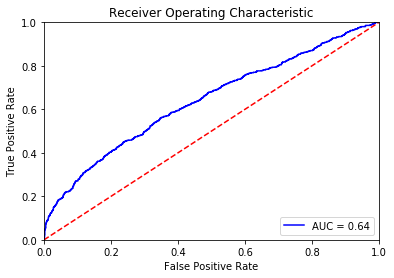

/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bhavi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[1175  197]
 [ 707  364]] 
 0.6299631600491199 

 [[10702  1476]
 [ 6327  3481]] 
 0.6450923314836714 

Precision Recall Score = 0.5099195255449902 


Classification Report
               precision    recall  f1-score   support

         0.0       0.62      0.86      0.72      1372
         1.0       0.65      0.34      0.45      1071

    accuracy                           0.63      2443
   macro avg       0.64      0.60      0.58      2443
weighted avg       0.64      0.63      0.60      2443




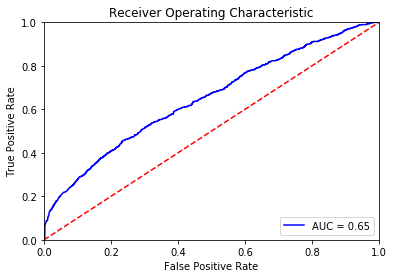

In [57]:
X = data.loc[:, (data.columns != 'is_goal') & (data.columns != 'shot_id_number') ].values
y = data[['is_goal']].values

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# ct = ColumnTransformer(
#     [('one_hot_encoder', OneHotEncoder(), [5, 6, 7, 8, 10, 11])],    # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
#     remainder='passthrough'                         # Leave the rest of the columns untouched
# )

# X = np.array(ct.fit_transform(X), dtype=np.float)


from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0) # from 10 observations- 2 in test set and 8 in training set, random state is not necessary

''' Feature Scaling '''
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train =sc_X.fit_transform(X_train)
X_test =sc_X.transform(X_test)
# debate on scaling dummy variablesm

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state = 0)
logistic.fit(X_train, y_train)
y_pred_train = logistic.predict(X_train)

# Predicting the Test set results
y_pred = logistic.predict(X_test)

evaluatePredictions(y_test, y_pred, y_train, y_pred_train, logistic)

from xgboost import XGBClassifier
xboost_classifier = XGBClassifier()
xboost_classifier.fit(X_train, y_train)

y_pred_train = xboost_classifier.predict(X_train)
y_pred = xboost_classifier.predict(X_test)

evaluatePredictions(y_test, y_pred, y_train, y_pred_train, xboost_classifier)
probs = xboost_classifier.predict_proba(X_test)


# from sklearn.svm import SVC
# classifier = SVC(kernel = 'rbf', random_state = 0)
# classifier.fit(X_train, y_train)

# y_pred_train = classifier.predict(X_train)
# y_pred = classifier.predict(X_test)

# evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)


# from sklearn.neighbors import KNeighborsClassifier
# classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
# classifier.fit(X_train, y_train)

# y_pred_train = classifier.predict(X_train)
# y_pred = classifier.predict(X_test)

# evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)


# Fitting Random Forest Classification to the Training set
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, y_train)

# y_pred_train = classifier.predict(X_train)
# y_pred = classifier.predict(X_test)

# evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)

In [67]:
X = submission[X_cols].values
# y = submission[['is_goal']].values
submission.shape

# print (X.shape)

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# ct = ColumnTransformer(
#     [('one_hot_encoder', OneHotEncoder(), [5, 6, 7, 8, 10, 11])],    # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
#     remainder='passthrough'                         # Leave the rest of the columns untouched
# )

# X = np.array(ct.fit_transform(X), dtype=np.float)

# print(X.shape)

# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0) # from 10 observations- 2 in test set and 8 in training set, random state is not necessary

# ''' Feature Scaling '''
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =sc_X.fit_transform(X)

probs = xboost_classifier.predict_proba(X)

In [68]:
solution = pd.DataFrame(columns=['shot_id_number', 'is_goal'])

solution['shot_id_number'] = submission['shot_id_number']
solution['is_goal'] = probs

In [69]:
solution.to_csv("bhavi_chawla_280998_code_2.csv",index=False)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import learning_curve, GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# train = pd.read_csv('train_modified.csv')
# target = 'Disbursed'
# IDcol = 'ID'

train = data[X_cols].values
target = data[['is_goal']].values


def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

#Choose all predictors except targe
predictors = [x for x in train.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)




In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), [5, 6, 7, 8, 10, 11])],    # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                         # Leave the rest of the columns untouched
)

X = np.array(ct.fit_transform(X), dtype=np.float)

In [ ]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0) # from 10 observations- 2 in test set and 8 in training set, random state is not necessary

In [ ]:
X_train.shape, y_train.sum(), y_train.sum()/X_train.shape[0]
# y_test.value_counts(normalize=True)

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# X_train, y_train = x_train_res, y_train_res

In [ ]:
X_train.shape, y_train.sum(), y_train.sum()/X_train.shape[0]
# y_test.value_counts(normalize=True)

In [ ]:
''' Feature Scaling '''
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train =sc_X.fit_transform(X_train)
X_test =sc_X.transform(X_test)
# debate on scaling dummy variablesm

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)

evaluatePredictions(y_test, y_pred, y_train, y_pred_train, classifier)
probs = classifier.predict_proba(X_test)

In [ ]:
#Submission

